Je tente en utilisant les instructions dans oml2 et oml3 de faire des requetes sur les le secteur des cimentiers

In [2]:
from pyeutl.orm import DataAccessLayer

connectionSettings = dict(
    user="postgres", 
    host="localhost", 
    db="eutl2024", 
    passw="password",
    port=5432
)



- Rajouter dans PATH des variables système le lien vers POSTGRES:
`C:\Program Files\PostgreSQL\17\bin`
- Puis lancer cette commande dans le terminal pour s'assurer du bon fonctionnement des credentials donnés ci-dessus et de POSTGRES:
`psql -h localhost -p 5432 -U postgres -W`

- Si le code d'en dessous ne fonctionne toujours pas, créer une base de données appelée EU ETL
en relançant:
``psql -h localhost -p 5432 -U postgres -W``

puis en entrant le mdp: password et puis en compilant:
postgres=#`CREATE DATABASE eutl2024`;

-> j'ai appuyé sur echap lors du pop up qui demande si il peut supprimer les tables existantes (mais peut etre inutile vue qu'il n'y a pas de tables dans eutl2024)



In [3]:
#création de la base de données
dal = DataAccessLayer(**connectionSettings)
#creation de la base


In [3]:
#dal.create_database()

In [4]:
from pyeutl.orm import Installation       # EUETS Installation object
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

session = dal.session

## Partie 1: Cimentiers

In [6]:
from pyeutl.orm import NaceCode
from sqlalchemy import select,func
session.rollback()  # Annule la transaction en cours


In [7]:
from pyeutl.orm import Installation, Transaction,Account

stmt = select(Installation.id).where(Installation.nace_id == "23.51")
cement_installation_ids = session.scalars(stmt).all()

print(f"Installations liées au NACE 23.51 : {len(cement_installation_ids)}")


Installations liées au NACE 23.51 : 306


In [7]:
stmt = select(Account.id).where(Account.installation_id.in_(cement_installation_ids))
cement_account_ids = session.scalars(stmt).all()

print(f" Comptes liés aux installations cimentières : {len(cement_account_ids)}")


 Comptes liés aux installations cimentières : 585


In [8]:
stmt = select(
    func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.acquiringAccount_id.in_(cement_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
cement_acquiring_amounts = session.execute(stmt).fetchall()

print(f"Transactions aquisitions liées aux comptes de cimentiers : {cement_acquiring_amounts}")


Transactions aquisitions liées aux comptes de cimentiers : [(Decimal('2005'), Decimal('96549992')), (Decimal('2006'), Decimal('228448629')), (Decimal('2007'), Decimal('175344449')), (Decimal('2008'), Decimal('249789363')), (Decimal('2009'), Decimal('205596087')), (Decimal('2010'), Decimal('226149636')), (Decimal('2011'), Decimal('243529860')), (Decimal('2012'), Decimal('257476583')), (Decimal('2013'), Decimal('96342330')), (Decimal('2014'), Decimal('304091369')), (Decimal('2015'), Decimal('164973993')), (Decimal('2016'), Decimal('153008360')), (Decimal('2017'), Decimal('152221148')), (Decimal('2018'), Decimal('150270122')), (Decimal('2019'), Decimal('152682502')), (Decimal('2020'), Decimal('162552671')), (Decimal('2021'), Decimal('71120591'))]


In [9]:
stmt = select(func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.transferringAccount_id.in_(cement_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
cement_sending_amounts = session.execute(stmt).fetchall()

print(f"Transactions transfert liées aux comptes de cimentiers : {cement_sending_amounts}")


Transactions transfert liées aux comptes de cimentiers : [(Decimal('2005'), Decimal('3731703')), (Decimal('2006'), Decimal('177388117')), (Decimal('2007'), Decimal('168395349')), (Decimal('2008'), Decimal('284013233')), (Decimal('2009'), Decimal('209185354')), (Decimal('2010'), Decimal('229630091')), (Decimal('2011'), Decimal('248625118')), (Decimal('2012'), Decimal('239326358')), (Decimal('2013'), Decimal('191910252')), (Decimal('2014'), Decimal('217667449')), (Decimal('2015'), Decimal('163739439')), (Decimal('2016'), Decimal('162467114')), (Decimal('2017'), Decimal('143171833')), (Decimal('2018'), Decimal('153653519')), (Decimal('2019'), Decimal('158572721')), (Decimal('2020'), Decimal('159556744')), (Decimal('2021'), Decimal('143248735'))]


1) Les allocations du marché primaire, mise aux en enchères:
amount avec transferringAccount dans cette liste:
- ICE UK Auction Trust Account -DECC
- ECC AG Handel
- ECC AG Handel Backup
- ECC Luxembourg SARL Primärhandel



In [9]:
#recupérer les IDS des comptes institutionnels 

institution_names = [
    "UK Auction Trust Account - DECC",
    "ECC AG Handel",
    "ECC AG Handel Backup",
    "ECC Luxemburg Sarl Primärhandel"
]

# Requête pour récupérer les account_id correspondants
stmt = select(Account.id).where(Account.name.in_(institution_names))
institution_accounts_ids = session.scalars(stmt).all()
institution_accounts_ids

[106390, 106468, 106346, 106347]

In [11]:
# 🔹 Requête pour obtenir le nombre de transactions et la somme des montants par année
stmt = select(
    func.extract('year', Transaction.date).label("year"),  # Extraction de l'année
    func.count(Transaction.id).label("transaction_count"),  # Nombre de transactions
    func.sum(Transaction.amount).label("total_amount")  # Somme des montants
).where(
    Transaction.transferringAccount_id.in_(institution_accounts_ids)  # Correction du champ
).group_by(
    func.extract('year', Transaction.date)  # Regrouper par année
).order_by(
    func.extract('year', Transaction.date)  # Trier par année
)

# 🔹 Exécution de la requête
institutions_transactions = session.execute(stmt).fetchall()

# 🔹 Affichage des résultats
for inst in institutions_transactions:
    print(f" Année: {inst[0]} |  Nb de transferts: {inst[1]} |  Somme des transferts: {inst[2]}")


 Année: 2012 |  Nb de transferts: 249 |  Somme des transferts: 144789283
 Année: 2013 |  Nb de transferts: 2049 |  Somme des transferts: 879271586
 Année: 2014 |  Nb de transferts: 1633 |  Somme des transferts: 650569634
 Année: 2015 |  Nb de transferts: 1606 |  Somme des transferts: 687410667
 Année: 2016 |  Nb de transferts: 1983 |  Somme des transferts: 795655187
 Année: 2017 |  Nb de transferts: 1927 |  Somme des transferts: 1007313194
 Année: 2018 |  Nb de transferts: 2124 |  Somme des transferts: 1058901054
 Année: 2019 |  Nb de transferts: 2007 |  Somme des transferts: 734710610
 Année: 2020 |  Nb de transferts: 2183 |  Somme des transferts: 843192222
 Année: 2021 |  Nb de transferts: 1777 |  Somme des transferts: 467609193


In [10]:
# 🔹 Requête pour obtenir le nombre de transactions et la somme des montants par année
stmt = select(
    func.extract('year', Transaction.date).label("year"),  # Extraction de l'année
    func.count(Transaction.id).label("transaction_count"),  # Nombre de transactions
    func.sum(Transaction.amount).label("total_amount")  # Somme des montants
).where(
    Transaction.acquiringAccount_id.in_(institution_accounts_ids)  # Correction du champ
).group_by(
    func.extract('year', Transaction.date)  # Regrouper par année
).order_by(
    func.extract('year', Transaction.date)  # Trier par année
)

# 🔹 Exécution de la requête
institutions_transactions = session.execute(stmt).fetchall()

# 🔹 Affichage des résultats
for inst in institutions_transactions:
    print(f" Année: {inst[0]} |  Nb de transferts: {inst[1]} |  Somme des transferts: {inst[2]}")


 Année: 2012 |  Nb de transferts: 146 |  Somme des transferts: 157948783
 Année: 2013 |  Nb de transferts: 458 |  Somme des transferts: 940250934
 Année: 2014 |  Nb de transferts: 734 |  Somme des transferts: 664268773
 Année: 2015 |  Nb de transferts: 389 |  Somme des transferts: 664494490
 Année: 2016 |  Nb de transferts: 415 |  Somme des transferts: 773144000
 Année: 2017 |  Nb de transferts: 451 |  Somme des transferts: 1006977154
 Année: 2018 |  Nb de transferts: 542 |  Somme des transferts: 1071137446
 Année: 2019 |  Nb de transferts: 407 |  Somme des transferts: 717415502
 Année: 2020 |  Nb de transferts: 474 |  Somme des transferts: 858376096
 Année: 2021 |  Nb de transferts: 348 |  Somme des transferts: 495654359


Remarque 1: Très peu de transaction en nombre de la part des institutions ...?

Remarque 2: Ne commencent qu'en 2012?? 
-> oui car le système de mise aux enchères ne commence qu'à partir de 2012


In [12]:
#dans la liste des transactions de cimentier, recupérer les transactions avec
# les transfering account = institutions
stmt = select(Transaction.id).where(
    (Transaction.acquiringAccount_id.in_(institution_accounts_ids)) 
    &(Transaction.transferringAccount_id.in_(cement_account_ids))
)
#
# Exécution de la requête
cement_allocations_id = session.scalars(stmt).all()
cement_allocations_id


[]

-> Pas d'achat sur le marché primaire pour les cimentiers ?

Allocations gratuites:

In [13]:
from pyeutl.orm import Compliance

from sqlalchemy import func
stmt = select(
    Compliance.year,  # Group by year
    func.sum(Compliance.allocatedTotal)  # Sum of allocatedTotal
).where(Compliance.installation_id.in_(cement_installation_ids)).group_by(Compliance.year).order_by(Compliance.year)

# Exécution de la requête
cement_allocation_free_amount = session.execute(stmt).fetchall()
print(cement_allocation_free_amount[:100])

[(2005, 154923557), (2006, 153998306), (2007, 164650197), (2008, 175593363), (2009, 176877004), (2010, 177577397), (2011, 177429573), (2012, 178920716), (2013, 140369930), (2014, 127346436), (2015, 126357518), (2016, 126269932), (2017, 122253151), (2018, 119133395), (2019, 118402668), (2020, 115867744), (2021, 95908534), (2022, 96324415), (2023, 96504330), (2024, 93930256), (2025, 93930256), (2026, 0), (2027, 0), (2028, 0), (2029, 0), (2030, 0)]


Emissions emises :

In [14]:
from pyeutl.orm import Surrender

smt = select( Surrender.year ,func.sum(Surrender.amount)
             ).where(
                 Surrender.installation_id.in_(cement_installation_ids) 
             ).group_by(Surrender.year).order_by(Surrender.year)
cement_emissions_amount = session.execute(smt).fetchall()
print(cement_emissions_amount)


[(2005, 107721245), (2006, 188733096), (2007, 165435663), (2008, 155380174), (2009, 132275858), (2010, 123928165), (2011, 116785844), (2012, 97546288), (2013, 112086086), (2014, 117104328), (2015, 114805273), (2016, 115734815), (2017, 118196692), (2018, 119769616), (2019, 119765316), (2020, 112705566), (2021, 109923093), (2022, 101970934), (2023, 94427540), (2024, 187736)]


Remarque 3: L'année devrait commencer le 1er mai en t en finir en 30 avril en t+1 mais Surrender, Compliance ne nous donnent qu'une année pas de mois, jours 

idée: aller relire Description EUTL pour voir si infos sur le "calcul" de l'année

In [15]:
import pandas as pd

#  Transformer chaque liste de tuples en DataFrame
df_acquiring = pd.DataFrame(cement_acquiring_amounts, columns=["Year", "Acquiring Amount"])
df_sending = pd.DataFrame(cement_sending_amounts, columns=["Year", "Sending Amount"])
df_allocation = pd.DataFrame(cement_allocation_free_amount, columns=["Year", "Allocated Free Amount"])
df_emissions = pd.DataFrame(cement_emissions_amount, columns=["Year", "Emissions Amount"])

#  Fusionner les DataFrames sur "Year"
df_merged = df_acquiring \
    .merge(df_sending, on="Year", how="outer") \
    .merge(df_allocation, on="Year", how="outer") \
    .merge(df_emissions, on="Year", how="outer")

#  Remplacer les NaN par 0 pour éviter les valeurs manquantes
df_merged.fillna(0, inplace=True)
df_merged["Transactions Nettes"] = df_merged["Acquiring Amount"] - df_merged["Sending Amount"]
df_merged["Montant total acquis"] = df_merged["Transactions Nettes"] + df_merged["Allocated Free Amount"]

#  Trier par année
df_merged = df_merged.sort_values(by="Year")
df_merged



,Year,Acquiring Amount,Sending Amount,Allocated Free Amount,Emissions Amount,Transactions Nettes,Montant total acquis
0,2005,96549992,3731703,154923557,107721245.0,92818289,247741846
1,2006,228448629,177388117,153998306,188733096.0,51060512,205058818
2,2007,175344449,168395349,164650197,165435663.0,6949100,171599297
3,2008,249789363,284013233,175593363,155380174.0,-34223870,141369493
4,2009,205596087,209185354,176877004,132275858.0,-3589267,173287737
5,2010,226149636,229630091,177577397,123928165.0,-3480455,174096942
6,2011,243529860,248625118,177429573,116785844.0,-5095258,172334315
7,2012,257476583,239326358,178920716,97546288.0,18150225,197070941
8,2013,96342330,191910252,140369930,112086086.0,-95567922,44802008
9,2014,304091369,217667449,127346436,117104328.0,86423920,213770356


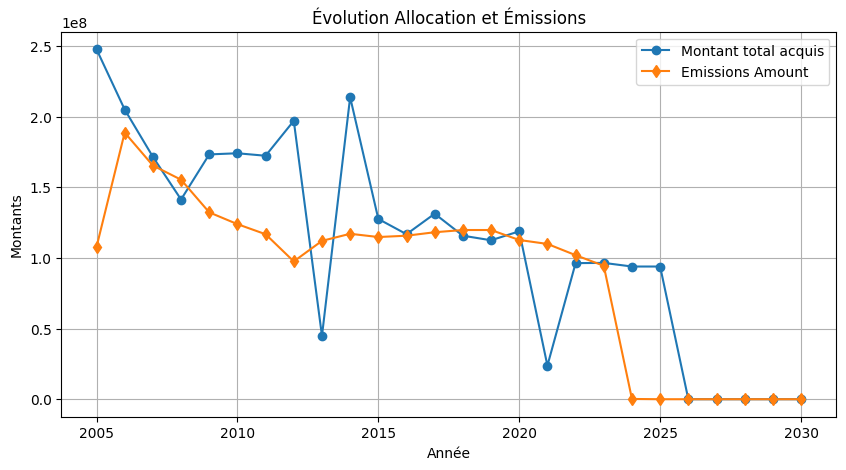

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Tracer les courbes
plt.plot(df_merged["Year"], df_merged["Montant total acquis"], label="Montant total acquis", marker="o")
plt.plot(df_merged["Year"], df_merged["Emissions Amount"], label="Emissions Amount", marker="d")

# Ajouter des légendes et titres
plt.xlabel("Année")
plt.ylabel("Montants")
plt.title("Évolution Allocation et Émissions")
plt.legend()
plt.grid(True)

#  Affichage du graphique
plt.show()

voir pq baisse en 2008, 2012 et 2021

essayer avec un autre secteur (flat glass sector)

european environmental agency carbon market dashboard

Le Secteur des flat glass

In [17]:
#installations
stmt = select(Installation.id).where(Installation.nace_id.in_(["23.11","23.12"]))
glass_installation_ids = session.scalars(stmt).all()

#account
stmt = select(Account.id).where(Account.installation_id.in_(glass_installation_ids))
glass_account_ids = session.scalars(stmt).all()

#acquisition
stmt = select(
    func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.acquiringAccount_id.in_(glass_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
glass_acquiring_amounts = session.execute(stmt).fetchall()


#transferts

stmt = select(func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.transferringAccount_id.in_(glass_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
glass_sending_amounts = session.execute(stmt).fetchall()


#regarder transferts  secteurs primaires pour voir si meme schema que  ciment

stmt = select(Transaction.id).where(
    (Transaction.transferringAccount_id.in_(institution_accounts_ids)) 
    &(Transaction.acquiringAccount_id.in_(glass_account_ids))
)
#
# Exécution de la requête
glass_allocations_id = session.scalars(stmt).all()



#Allocations gratuites
stmt = select(
    Compliance.year,  # Group by year
    func.sum(Compliance.allocatedTotal)  # Sum of allocatedTotal
).where(Compliance.installation_id.in_(glass_installation_ids)).group_by(Compliance.year).order_by(Compliance.year)

# Exécution de la requête
glass_allocation_free_amount = session.execute(stmt).fetchall()


#émissions


smt = select( Surrender.year ,func.sum(Surrender.amount)
             ).where(
                 Surrender.installation_id.in_(glass_installation_ids) 
             ).group_by(Surrender.year).order_by(Surrender.year)
glass_emissions_amount = session.execute(smt).fetchall()




In [18]:
#Pareil aucune transaction avec les institutions
glass_allocations_id

[]

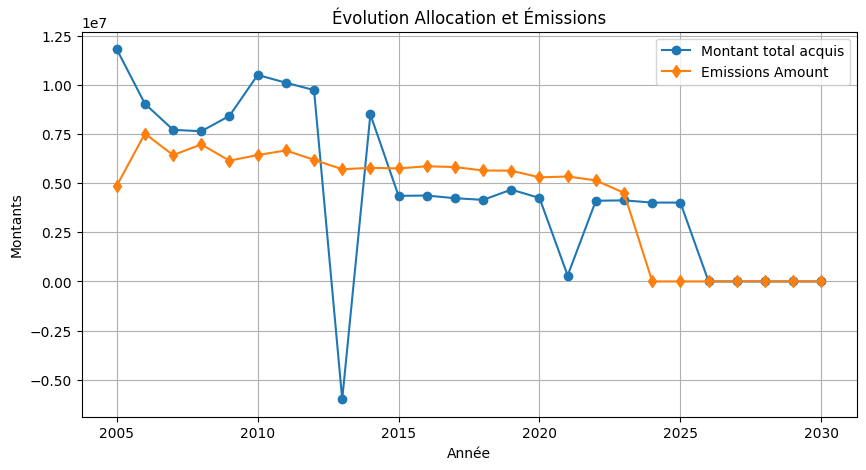

In [19]:
import matplotlib.pyplot as plt



import pandas as pd

#  Transformer chaque liste de tuples en DataFrame
df_acquiring = pd.DataFrame(glass_acquiring_amounts, columns=["Year", "Acquiring Amount"])
df_sending = pd.DataFrame(glass_sending_amounts, columns=["Year", "Sending Amount"])
df_allocation = pd.DataFrame(glass_allocation_free_amount, columns=["Year", "Allocated Free Amount"])
df_emissions = pd.DataFrame(glass_emissions_amount, columns=["Year", "Emissions Amount"])

#  Fusionner les DataFrames sur "Year"
df_merged = df_acquiring \
    .merge(df_sending, on="Year", how="outer") \
    .merge(df_allocation, on="Year", how="outer") \
    .merge(df_emissions, on="Year", how="outer")

#  Remplacer les NaN par 0 pour éviter les valeurs manquantes
df_merged.fillna(0, inplace=True)
df_merged["Transactions Nettes"] = df_merged["Acquiring Amount"] - df_merged["Sending Amount"]
df_merged["Montant total acquis"] = df_merged["Transactions Nettes"] + df_merged["Allocated Free Amount"]

#  Trier par année
df_merged = df_merged.sort_values(by="Year")
df_merged


plt.figure(figsize=(10, 5))

# Tracer les courbes
plt.plot(df_merged["Year"], df_merged["Montant total acquis"], label="Montant total acquis", marker="o")
plt.plot(df_merged["Year"], df_merged["Emissions Amount"], label="Emissions Amount", marker="d")

# Ajouter des légendes et titres
plt.xlabel("Année")
plt.ylabel("Montants")
plt.title("Évolution Allocation et Émissions")
plt.legend()
plt.grid(True)

#  Affichage du graphique
plt.show()

Montant total acquis: Transactions Nettes + allocations gratuites

In [20]:
df_acquiring

,Year,Acquiring Amount
0,2005,4845417
1,2006,8715850
2,2007,7938426
3,2008,10347078
4,2009,10182487
5,2010,9241973
6,2011,9924450
7,2012,13195079
8,2013,5487584
9,2014,12959166


Grosse perte en 2013 -> dû à un changement de phase ?

Idée: ajouter les entitlements? -> demander à Laetitia si elle sait ou trouver les entitlements 


Test avec secteur électrique (Electricity, gas, steam and air conditioning supply): code NACE 35

In [21]:
#installations
stmt = select(Installation.id).where(Installation.nace_id=="35")
electricity_installation_ids = session.scalars(stmt).all()

#account
stmt = select(Account.id).where(Account.installation_id.in_(electricity_installation_ids))
electricity_account_ids = session.scalars(stmt).all()

#acquisition
stmt = select(
    func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.acquiringAccount_id.in_(electricity_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
electricity_acquiring_amounts = session.execute(stmt).fetchall()


#transferts

stmt = select(func.extract('year', Transaction.date), 
    func.sum(Transaction.amount)).where(
    (Transaction.transferringAccount_id.in_(electricity_account_ids)) 
).group_by(func.extract('year', Transaction.date)).order_by(func.extract('year', Transaction.date))
electricity_sending_amounts = session.execute(stmt).fetchall()


#regarder transferts  secteurs primaires pour voir si meme schema que  ciment

stmt = select(Transaction.id).where(
    (Transaction.transferringAccount_id.in_(institution_accounts_ids)) 
    &(Transaction.acquiringAccount_id.in_(electricity_account_ids))
)
#
# Exécution de la requête
electricity_allocations_id = session.scalars(stmt).all()



#Allocations gratuites
stmt = select(
    Compliance.year,  # Group by year
    func.sum(Compliance.allocatedTotal)  # Sum of allocatedTotal
).where(Compliance.installation_id.in_(electricity_installation_ids)).group_by(Compliance.year).order_by(Compliance.year)

# Exécution de la requête
electricity_allocation_free_amount = session.execute(stmt).fetchall()


#émissions


smt = select( Surrender.year ,func.sum(Surrender.amount)
             ).where(
                 Surrender.installation_id.in_(electricity_installation_ids) 
             ).group_by(Surrender.year).order_by(Surrender.year)
electricity_emissions_amount = session.execute(smt).fetchall()




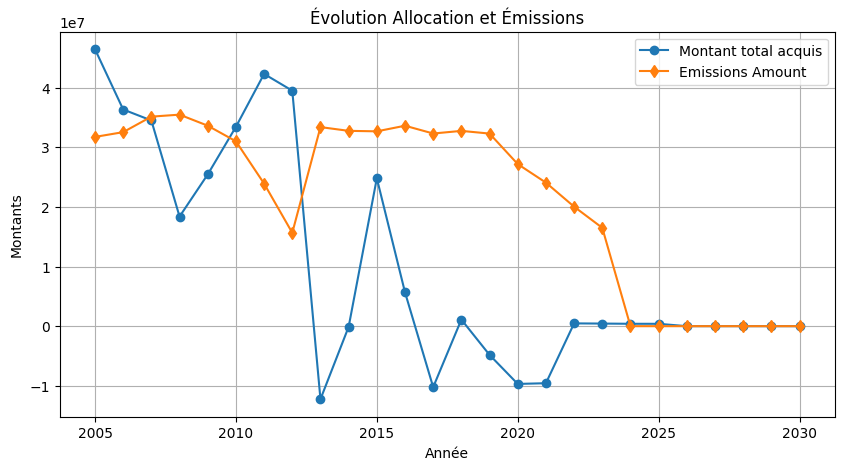

In [22]:
#  Transformer chaque liste de tuples en DataFrame
df_acquiring = pd.DataFrame(electricity_acquiring_amounts, columns=["Year", "Acquiring Amount"])
df_sending = pd.DataFrame(electricity_sending_amounts, columns=["Year", "Sending Amount"])
df_allocation = pd.DataFrame(electricity_allocation_free_amount, columns=["Year", "Allocated Free Amount"])
df_emissions = pd.DataFrame(electricity_emissions_amount, columns=["Year", "Emissions Amount"])

#  Fusionner les DataFrames sur "Year"
df_merged = df_acquiring \
    .merge(df_sending, on="Year", how="outer") \
    .merge(df_allocation, on="Year", how="outer") \
    .merge(df_emissions, on="Year", how="outer")

#  Remplacer les NaN par 0 pour éviter les valeurs manquantes
df_merged.fillna(0, inplace=True)
df_merged["Transactions Nettes"] = df_merged["Acquiring Amount"] - df_merged["Sending Amount"]
df_merged["Montant total acquis"] = df_merged["Transactions Nettes"] + df_merged["Allocated Free Amount"]

#  Trier par année
df_merged = df_merged.sort_values(by="Year")
df_merged


plt.figure(figsize=(10, 5))

# Tracer les courbes
plt.plot(df_merged["Year"], df_merged["Montant total acquis"], label="Montant total acquis", marker="o")
plt.plot(df_merged["Year"], df_merged["Emissions Amount"], label="Emissions Amount", marker="d")

# Ajouter des légendes et titres
plt.xlabel("Année")
plt.ylabel("Montants")
plt.title("Évolution Allocation et Émissions")
plt.legend()
plt.grid(True)

#  Affichage du graphique
plt.show()

In [23]:
df_acquiring

,Year,Acquiring Amount
0,2005,23590962
1,2006,37460459
2,2007,46671369
3,2008,49851050
4,2009,46080862
5,2010,50145011
6,2011,75712235
7,2012,66438172
8,2013,36406583
9,2014,52392472


Que se passe t'il en 2013??

Je récupère toutes les données par année et par nace_id

In [24]:
import pandas as pd
from collections import defaultdict

# Liste pour collecter toutes les lignes de données
data_rows = []

stmt = select(Installation.id, Installation.nace_id)
installation_ids_by_nace = session.execute(stmt).fetchall()

installations_dict = defaultdict(list)
for installation_id, nace_id in installation_ids_by_nace:
    installations_dict[nace_id].append(installation_id)

for nace_id, installation_ids in installations_dict.items():
    # Comptes liés aux installations
    stmt = select(Account.id).where(Account.installation_id.in_(installation_ids))
    account_ids = session.scalars(stmt).all()

    # Transactions acquises
    stmt = select(
        func.extract('year', Transaction.date).label('year'),
        func.sum(Transaction.amount).label('acquired_amount')
    ).where(
        Transaction.acquiringAccount_id.in_(account_ids)
    ).group_by('year').order_by('year')
    acquiring_amounts = session.execute(stmt).fetchall()

    # Transactions envoyées
    stmt = select(
        func.extract('year', Transaction.date).label('year'),
        func.sum(Transaction.amount).label('transferred_amount')
    ).where(
        Transaction.transferringAccount_id.in_(account_ids)
    ).group_by('year').order_by('year')
    sending_amounts = session.execute(stmt).fetchall()


    #Ventes aux enchères:
     
    stmt = select(
        func.extract('year', Transaction.date).label('year'),
        func.sum(Transaction.amount).label('auctions_amount')
    ).where(
        (Transaction.transferringAccount_id.in_(institution_accounts_ids)) 
        &(Transaction.acquiringAccount_id.in_(account_ids))
    ).group_by('year').order_by('year')
    
    auctions_amounts = session.execute(stmt).fetchall()
  
    
    # Allocations gratuites
    stmt = select(
        Compliance.year.label('year'),
        func.sum(Compliance.allocatedTotal).label('free_allocations')
    ).where(
        Compliance.installation_id.in_(installation_ids)
    ).group_by('year').order_by('year')
    free_allocation_amounts = session.execute(stmt).fetchall()

    # Émissions
    stmt = select(
        Surrender.year.label('year'),
        func.sum(Surrender.amount).label('emissions')
    ).where(
        Surrender.installation_id.in_(installation_ids)
    ).group_by('year').order_by('year')
    emissions_amounts = session.execute(stmt).fetchall()

    # Créer une entrée de données pour chaque année
    years = {year for year, _ in (acquiring_amounts + sending_amounts + free_allocation_amounts + emissions_amounts)}
    for year in years:
        row = {
            "nace_id": nace_id,
            "year": year,
            "acquired_amount": next((amount for yr, amount in acquiring_amounts if yr == year), 0),
            "transferred_amount": next((amount for yr, amount in sending_amounts if yr == year), 0),
            "auctions":next((amount for yr, amount in auctions_amounts if yr == year), 0),
            "free_allocations": next((amount for yr, amount in free_allocation_amounts if yr == year), 0),
            "emissions": next((amount for yr, amount in emissions_amounts if yr == year), 0)
        }
        data_rows.append(row)

# Créer le DataFrame à partir de la liste de données
results = pd.DataFrame(data_rows)

# Afficher les premières lignes du DataFrame pour vérifier
print(results.head())


  nace_id  year acquired_amount transferred_amount auctions  free_allocations  \
0    51.0  2005               0                  0        0                 0   
1    51.0  2006               0                  0        0                 0   
2    51.0  2007               0                  0        0                 0   
3    51.0  2008               0                  0        0                 0   
4    51.0  2009               0                  0        0                 0   

   emissions  
0          0  
1          0  
2          0  
3          0  
4          0  


In [25]:
results.head(20)

,nace_id,year,acquired_amount,transferred_amount,auctions,free_allocations,emissions
0,51.0,2005,0,0,0,0,0
1,51.0,2006,0,0,0,0,0
2,51.0,2007,0,0,0,0,0
3,51.0,2008,0,0,0,0,0
4,51.0,2009,0,0,0,0,0
5,51.0,2010,0,0,0,0,0
6,51.0,2011,0,0,0,0,0
7,51.0,2012,115773701,8186658,0,173816340,76931052
8,51.0,2013,56431595,154799286,2000,32411029,85599
9,51.0,2014,30345462,4444670,1475000,32245756,99074122


In [26]:

#on veur s'assurer que meme les années sans data pour un nace_id, 
# sont bien représentées dans le dataframe
results.groupby('year')['nace_id'].nunique().reset_index(name='unique_nace_count')
#c'est le cas

,year,unique_nace_count
0,2005,284
1,2006,284
2,2007,284
3,2008,284
4,2009,284
5,2010,284
6,2011,284
7,2012,284
8,2013,284
9,2014,284


In [27]:
#prendre les émissions de l'année précédente

years = range(2005, 2031)  # 2025 car range est exclusif à la fin

# Obtenir les identifiants uniques de nace_id présents dans df
nace_ids = results['nace_id'].unique()

# Créer un DataFrame avec toutes les combinaisons possibles de nace_id et year
from itertools import product
all_combinations = pd.DataFrame(list(product(nace_ids, years)), columns=['nace_id', 'year'])

# Fusionner ce DataFrame avec le DataFrame original
results = pd.merge(all_combinations, results, on=['nace_id', 'year'], how='left')

# Remplacer les valeurs NaN par 0 dans les colonnes autres que 'nace_id' et 'year'
for column in ['acquired_amount', 'transferred_amount', 'free_allocations', 'emissions']:
    results[column].fillna(0, inplace=True)

# Trier le DataFrame pour de meilleures visualisations et analyses futures
results.sort_values(by=['nace_id', 'year'], inplace=True)

# Utiliser `groupby` sur 'nace_id' et `shift` pour ajuster les émissions à l'année précédente
results['emissions2'] = results.groupby('nace_id')['emissions'].shift(+1)

# Remplir les valeurs NaN dans la colonne des émissions décalées avec 0
results['emissions2'].fillna(0, inplace=True)

results.drop(columns=["emissions"],inplace=True)

# Afficher les premières lignes du DataFrame pour vérifier les modifications
results.head(20)

C:\Users\zoero\AppData\Local\Temp\ipykernel_20372\1231395213.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results[column].fillna(0, inplace=True)
C:\Users\zoero\AppData\Local\Temp\ipykernel_20372\1231395213.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

,nace_id,year,acquired_amount,transferred_amount,auctions,free_allocations,emissions2
6994,01.11,2005,0,0,0,0,0.0
6995,01.11,2006,0,0,0,0,0.0
6996,01.11,2007,0,0,0,0,0.0
6997,01.11,2008,0,0,0,0,0.0
6998,01.11,2009,0,0,0,0,0.0
6999,01.11,2010,0,0,0,0,0.0
7000,01.11,2011,0,0,0,0,0.0
7001,01.11,2012,0,0,0,0,0.0
7002,01.11,2013,0,0,0,5099,0.0
7003,01.11,2014,9662,6955,0,4563,6955.0


In [28]:
results.to_csv("data_by_nace_code.csv")

PARTIE 2: Cette fois, pour faire comme dans l'article, je groupe par type d'account et par nace_code

In [ ]:

from sqlalchemy import select, func, join
from collections import defaultdict
from pyeutl.orm import AccountType  # Assurez-vous que ces importations sont correctes

# Liste pour collecter toutes les lignes de données
data_rows = []

stmt = select(Installation.id, Installation.nace_id)
installation_ids_by_nace = session.execute(stmt).fetchall()

installations_dict = defaultdict(list)
for installation_id, nace_id in installation_ids_by_nace:
    installations_dict[nace_id].append(installation_id)
for nace_id, installation_ids in installations_dict.items():
    # Comptes liés aux installations avec le type de compte via une jointure
    stmt = select(
        Account.accountHolder ,
        AccountType.description.label('account_type'),
        Installation.nace_id
    ).select_from(
        Account
    ).join(
        AccountType, Account.accountType_id == AccountType.id
    ).join(
        Installation, Account.installation_id == Installation.id
    ).where(
        Installation.id.in_(installation_ids)  # Filtre les comptes par installation_id
    )
    account_info = session.execute(stmt).fetchall()

    for account_id, account_type, nace_id in account_info:
        # Transactions acquises, envoyées, ventes aux enchères, allocations gratuites, et émissions
        # pour tous les comptes de ce type et nace_id en agrégeant par année
        stmt = select(
            func.extract('year', Transaction.date).label('year'),
            func.sum(Transaction.amount).label('acquired_amount'),
            func.sum(Transaction.amount).label('transferred_amount'),
            func.sum(Transaction.amount).label('auctions_amount'),
            func.sum(Compliance.allocatedTotal).label('free_allocations'),
            func.sum(Surrender.amount).label('emissions')
        ).select_from(
            Transaction
        ).where(
            (Transaction.acquiringAccount_id == account_id) | (Transaction.transferringAccount_id == account_id)
        ).group_by(
            func.extract('year', Transaction.date)
        )
        
        results = session.execute(stmt).fetchall()

        for year, acquired, transferred, auctions, free_allocations, emissions in results:
            data_rows.append({
                "nace_id": nace_id,
                "account_type": account_type,
                "year": year,
                "acquired_amount": acquired,
                "transferred_amount": transferred,
                "auctions_amount": auctions,
                "free_allocations": free_allocations,
                "emissions": emissions
            })

# Créer le DataFrame à partir de la liste de données
results_df = pd.DataFrame(data_rows)

# Afficher les premières lignes du DataFrame pour vérifier
print(results_df.head())


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000024A93F19090>>
Traceback (most recent call last):
  File "c:\Users\zoero\OneDrive\Bureau\M2\S1\projet tutoré\code projet tuteuré\Banking-EU-ETS\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zoero\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1494, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


ArgumentError: SQL expression element or literal value expected, got <Account(90705, 'Air Charter Limited', 'AT', '100-9')>.

In [30]:
stmt = select(
        Account.accountHolder ,
        AccountType.description.label('account_type'),
        Installation.nace_id
    ).select_from(
        Account
    ).join(
        AccountType, Account.accountType_id == AccountType.id
    ).join(
        Installation, Account.installation_id == Installation.id
    )
account_info = session.execute(stmt).fetchall()

C:\Users\zoero\AppData\Local\Temp\ipykernel_20372\1544562789.py:12: SAWarning: SELECT statement has a cartesian product between FROM element(s) "account_holder" and FROM element "account_type_code".  Apply join condition(s) between each element to resolve.
  account_info = session.execute(stmt).fetchall()


OperationalError: (psycopg2.OperationalError) server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

[SQL: SELECT account_holder.id = account."accountHolder_id" AS anon_1, account_type_code.description AS account_type, installation.nace_id 
FROM account JOIN account_type_code ON account."accountType_id" = account_type_code.id JOIN installation ON account.installation_id = installation.id, account_holder]
(Background on this error at: https://sqlalche.me/e/20/e3q8)